# Supervised vs Unsupervised vs Self-Supervised Learning

Welcome to this guided notebook! We will explore three major paradigms in machine learning:

- **Supervised learning**, where models learn from labeled examples.
- **Unsupervised learning**, where the data has no labels and we look for structure.
- **Self-supervised learning**, where the data generates its own supervision through cleverly designed pretext tasks.

Each section mixes approachable explanations with executable code so that you can run the cells, inspect the output, and experiment. Feel free to modify parameters and re-run the cells to observe how the behaviour changes.

## How to Use This Notebook

- **Run the cells from top to bottom**. Later sections reuse variables created earlier.
- **Pause at the markdown blocks** (like this one) to build intuition before looking at the code.
- **Interact**: change the train/test split, the number of clusters, or the neural network settings and re-run the code to see what happens.
- **Take notes** on any observations—what surprised you, and what matched your expectations?

In [1]:
# Common imports used throughout the notebook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.datasets import load_iris, load_diabetes, load_digits, make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

plt.rcParams['figure.dpi'] = 120
np.random.seed(42)

## 1. Supervised Learning

In supervised learning we provide the model with **input features** (e.g. sepal length and width) **and known labels** (e.g. iris species). The model tries to learn a mapping from inputs to labels so that it can make predictions on new, unseen data. We measure success with metrics such as accuracy for classification or mean squared error for regression.

### 1.1 Classification Example — Iris Flowers

Goal: predict which species of iris a flower belongs to using two measurements. We use logistic regression, a classic linear classifier, because it is easy to interpret and fast to train.

In [2]:
# Load the iris dataset and focus on two features for simple visualisation
iris = load_iris()
feature_names = ['petal length (cm)', 'petal width (cm)']
X_classification = iris.data[:, 2:4]  # last two features
y_classification = iris.target

# Train/test split keeps 30% of the data for evaluation
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_classification, y_classification, test_size=0.3, stratify=y_classification, random_state=42
)

# Build a pipeline: standardise features then train logistic regression
log_reg_model = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=200)  # default settings handle multi-class automatically
)
log_reg_model.fit(X_train_clf, y_train_clf)

train_acc = log_reg_model.score(X_train_clf, y_train_clf)
test_acc = log_reg_model.score(X_test_clf, y_test_clf)

print(f"Training accuracy: {train_acc:.2f}")
print(f"Test accuracy: {test_acc:.2f}")

Training accuracy: 0.98
Test accuracy: 0.91


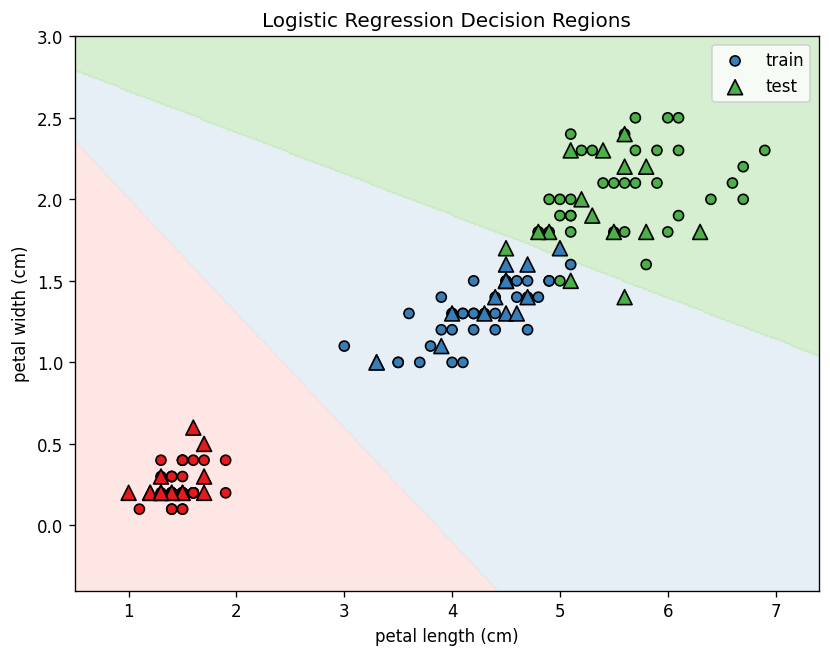

In [3]:
# Visualise the decision boundaries
cmap_light = ListedColormap(['#fde0dd', '#e0ecf4', '#ccebc5'])
cmap_bold = ['#e41a1c', '#377eb8', '#4daf4a']

# Create a dense grid of points covering the feature range
x_min, x_max = X_classification[:, 0].min() - 0.5, X_classification[:, 0].max() + 0.5
y_min, y_max = X_classification[:, 1].min() - 0.5, X_classification[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))

# Predict the class for each grid point
mesh_predictions = log_reg_model.predict(np.c_[xx.ravel(), yy.ravel()])
mesh_predictions = mesh_predictions.reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, mesh_predictions, cmap=cmap_light, alpha=0.8)
plt.scatter(X_train_clf[:, 0], X_train_clf[:, 1], c=y_train_clf, cmap=ListedColormap(cmap_bold), edgecolor='k', label='train')
plt.scatter(X_test_clf[:, 0], X_test_clf[:, 1], c=y_test_clf, cmap=ListedColormap(cmap_bold), edgecolor='k', marker='^', s=80, label='test')
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])
plt.title('Logistic Regression Decision Regions')
plt.legend()
plt.show()

### 1.2 Regression Example — Predicting Disease Progression

Goal: predict a numerical target (disease progression after one year) from a single medical measurement. Using a single feature keeps the plot interpretable and demonstrates how regression tries to fit a line that minimises error.

In [4]:
# Load the diabetes dataset

diabetes = load_diabetes()
feature_index = 2  # Body mass index feature
X_regression = diabetes.data[:, feature_index].reshape(-1, 1)
y_regression = diabetes.target

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_regression, y_regression, test_size=0.25, random_state=42
)

lin_reg_model = LinearRegression()
lin_reg_model.fit(X_train_reg, y_train_reg)

train_mse = mean_squared_error(y_train_reg, lin_reg_model.predict(X_train_reg))
test_mse = mean_squared_error(y_test_reg, lin_reg_model.predict(X_test_reg))
test_r2 = r2_score(y_test_reg, lin_reg_model.predict(X_test_reg))

print(f"Training MSE: {train_mse:.1f}")
print(f"Test MSE: {test_mse:.1f}")
print(f"Test R^2:  {test_r2:.2f}")

Training MSE: 3931.0
Test MSE: 3775.6
Test R^2:  0.32


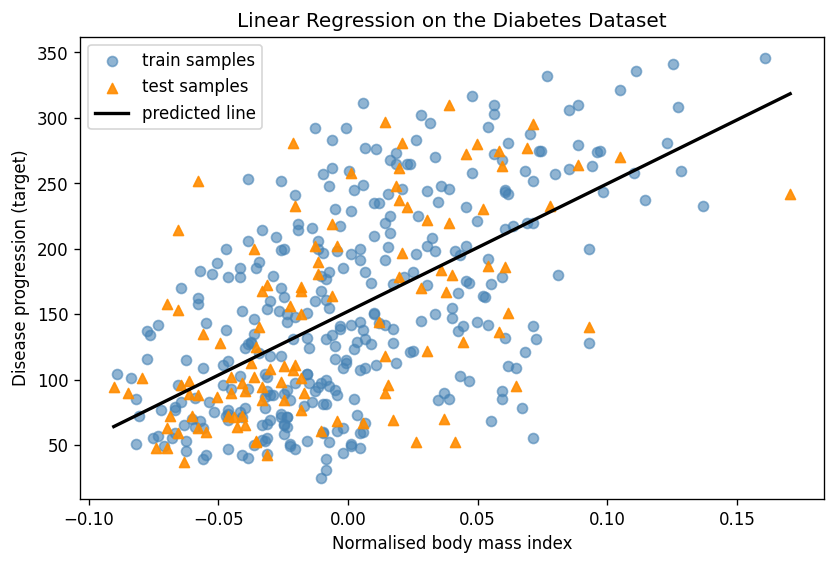

In [5]:
# Visualise the regression line alongside the data points
plt.figure(figsize=(8, 5))
plt.scatter(X_train_reg, y_train_reg, color='steelblue', alpha=0.6, label='train samples')
plt.scatter(X_test_reg, y_test_reg, color='darkorange', alpha=0.9, label='test samples', marker='^')

x_range = np.linspace(X_regression.min(), X_regression.max(), 100).reshape(-1, 1)
plt.plot(x_range, lin_reg_model.predict(x_range), color='black', linewidth=2, label='predicted line')

plt.xlabel('Normalised body mass index')
plt.ylabel('Disease progression (target)')
plt.title('Linear Regression on the Diabetes Dataset')
plt.legend()
plt.show()

**Takeaway:** Supervised learning needs labeled data. Collecting high-quality labels can be expensive, but it enables precise evaluation and direct feedback during training.

## 2. Unsupervised Learning

When labels are unavailable, we rely on unsupervised learning to uncover hidden structure. The goal might be to group similar items (clustering) or to reduce dimensionality for visualisation (manifold learning, PCA, etc.).

### 2.1 Clustering Example — Synthetic Customer Segments

We create synthetic 2D data with three natural clusters and apply k-means to recover those groups. Because the algorithm only sees the positions of the points, it assigns cluster IDs purely based on similarity.

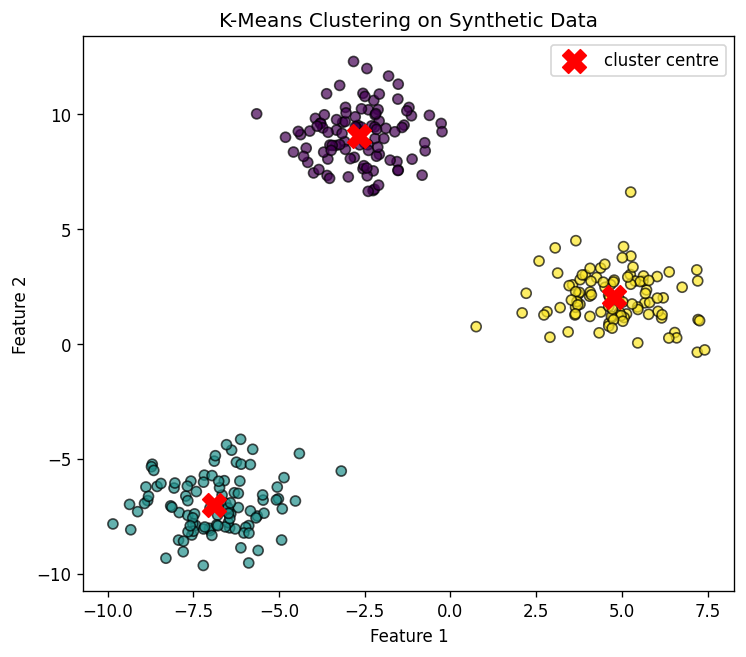

In [6]:
# Generate synthetic data and cluster with K-Means
X_blobs, _ = make_blobs(n_samples=300, centers=3, cluster_std=1.2, random_state=42)

kmeans = KMeans(n_clusters=3, n_init=10, random_state=42)
kmeans.fit(X_blobs)
labels = kmeans.labels_
centres = kmeans.cluster_centers_

plt.figure(figsize=(7, 6))
plt.scatter(X_blobs[:, 0], X_blobs[:, 1], c=labels, cmap='viridis', alpha=0.7, edgecolor='k')
plt.scatter(centres[:, 0], centres[:, 1], c='red', s=200, marker='X', label='cluster centre')
plt.title('K-Means Clustering on Synthetic Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

### 2.2 Dimensionality Reduction — Visualising Handwritten Digits

The digits dataset contains 8×8 images (64 dimensions). Plotting raw pixels is hard, so we use Principal Component Analysis (PCA) to compress the data into two components while preserving as much variance as possible.

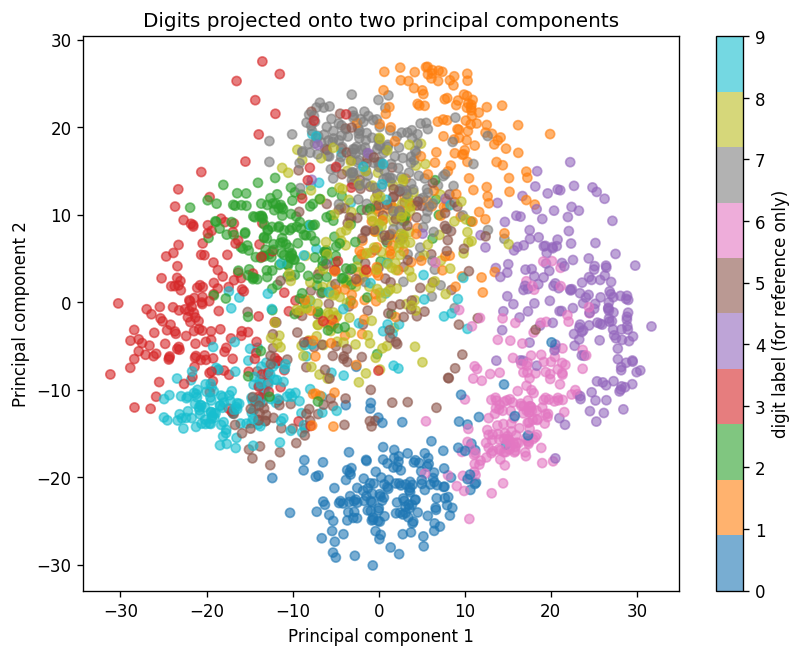

Variance captured by 2 components: 28.51%


In [7]:
# Load the digits dataset (no labels used for training PCA)
digits = load_digits()
X_digits = digits.data

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_digits)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=digits.target, cmap='tab10', alpha=0.6, s=30)
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
plt.title('Digits projected onto two principal components')
plt.colorbar(scatter, ticks=range(10), label='digit label (for reference only)')
plt.show()

print(f"Variance captured by 2 components: {pca.explained_variance_ratio_.sum():.2%}")

**Takeaway:** Unsupervised learning exposes latent structure without needing labels. The discovered groups or compressed features can then feed into downstream tasks or guide exploratory analysis.

## 3. Self-Supervised Learning

Self-supervised learning flips the script: we still have no human-provided labels, but we **create our own supervision** using the data itself. We design an auxiliary task (called a *pretext task*) whose solution forces the model to learn meaningful representations. After training, we reuse those representations for the task we actually care about.

Popular examples include:
- Predicting masked words in a sentence (BERT),
- Determining the rotation of an image,
- Reconstructing missing patches of an image or audio signal.

We will experiment with a rotation prediction task on handwritten digits.

### 3.1 Pretext Task — Predict the Rotation Angle of Digits

We start with the digits dataset again. This time we discard the digit labels and instead rotate each image by 0°, 90°, 180°, or 270°. The rotation angle becomes our self-generated label. Successfully solving this task requires the model to understand the structure of the digit shapes, even though we never told it what number each image represents.

In [8]:
# Prepare the self-supervised rotation dataset

# Helper: rotate an 8x8 image by multiples of 90 degrees
rotation_angles = [0, 1, 2, 3]  # number of 90° turns

images = digits.images  # shape (n_samples, 8, 8)
X_rotated = []
y_rotated = []

for img in images:
    for angle_label in rotation_angles:
        rotated = np.rot90(img, k=angle_label)
        X_rotated.append(rotated.ravel())  # flatten to 64 features
        y_rotated.append(angle_label)

X_rotated = np.array(X_rotated)
y_rotated = np.array(y_rotated)

print(f"Number of generated samples: {X_rotated.shape[0]}")
print(f"Feature dimension: {X_rotated.shape[1]}")

Number of generated samples: 7188
Feature dimension: 64


In [9]:
# Train a classifier to recover the rotation angle
X_train_rot, X_test_rot, y_train_rot, y_test_rot = train_test_split(
    X_rotated, y_rotated, test_size=0.2, stratify=y_rotated, random_state=42
)

rotation_model = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=300)  # multinomial training is enabled automatically
)
rotation_model.fit(X_train_rot, y_train_rot)

train_acc_rot = rotation_model.score(X_train_rot, y_train_rot)
test_acc_rot = rotation_model.score(X_test_rot, y_test_rot)

print(f"Rotation prediction training accuracy: {train_acc_rot:.2f}")
print(f"Rotation prediction test accuracy: {test_acc_rot:.2f}")

Rotation prediction training accuracy: 0.84
Rotation prediction test accuracy: 0.81


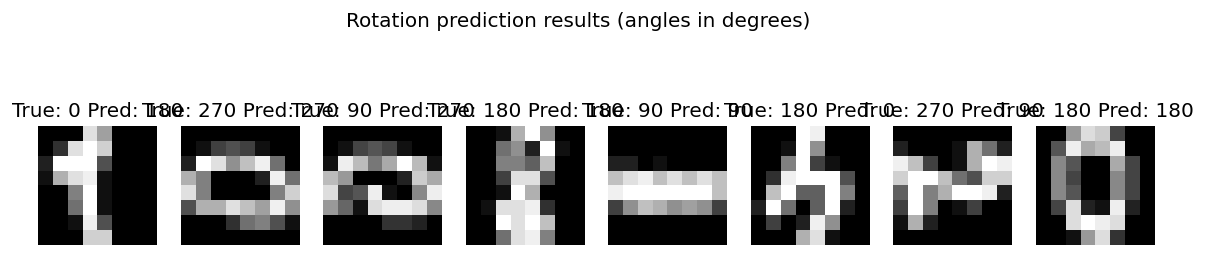

In [10]:
# Visualise a few original vs rotated images with predicted angles
num_examples = 8
example_indices = np.random.choice(len(X_test_rot), size=num_examples, replace=False)

plt.figure(figsize=(12, 3))
for idx, sample_idx in enumerate(example_indices, start=1):
    image_flat = X_test_rot[sample_idx]
    image_matrix = image_flat.reshape(8, 8)
    true_label = y_test_rot[sample_idx]
    predicted_label = rotation_model.predict([image_flat])[0]

    plt.subplot(1, num_examples, idx)
    plt.imshow(image_matrix, cmap='gray', interpolation='nearest')
    plt.axis('off')
    plt.title(f"True: {true_label * 90} Pred: {predicted_label * 90}")

plt.suptitle('Rotation prediction results (angles in degrees)')
plt.show()

### 3.2 Connecting Back to Downstream Tasks

Why go through this detour if we ultimately care about digit recognition? After training on the rotation task, we could reuse the learned representation (for example, the weights of a neural network) as a starting point for digit classification. In practice this often improves performance, especially when labeled data is scarce. Modern vision and language models rely heavily on self-supervised pretraining before fine-tuning on specific tasks.

## 4. Summary and Next Steps

- **Supervised learning** requires labels and offers direct feedback through metrics. It is the default choice when labeled data is abundant.
- **Unsupervised learning** reveals structure without labels—useful for exploration, compression, or feeding into later supervised steps.
- **Self-supervised learning** invents labels by transforming the data, letting us harness vast unlabeled datasets to learn rich representations.

**Keep exploring:**
1. Modify the synthetic datasets (e.g. add noise) and observe how the algorithms respond.
2. Swap logistic regression with other classifiers (e.g. k-nearest neighbours) and compare decision boundaries.
3. Extend the self-supervised section with a different pretext task, such as predicting whether an image was vertically flipped.

Happy experimenting!